In [18]:
from pulp import LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [16]:
# df_prices = pd.read_csv('BelpexFilter.csv', engine='python')
# df_prices.head()


# df.sort_values('timestamp', inplace=True)
# df.head()

In [19]:
df = pd.read_csv('Productie en verbruik info Core.csv', delimiter=';')
df.head()

,Datum,Tijd,Gemeenschappelijk verbruik in kW,Productie in kW
0,01.01.2017,0:00:00,10.715,0.0
1,01.01.2017,0:15:00,10.450,0.0
2,01.01.2017,0:30:00,10.685,0.0
3,01.01.2017,0:45:00,9.765,0.0
4,01.01.2017,1:00:00,9.505,0.0


In [24]:
# load1 = [0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0]
# load2 = [1,0,0,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,1]
# load1 = [val for val in load1 for _ in (0, 1, 2, 3)]
# load2 = [val for val in load2 for _ in (0, 1, 2, 3)]
# soc1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# soc2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# soc1 = [val for val in soc1 for _ in (0, 1, 2, 3)]
# soc2 = [val for val in soc2 for _ in (0, 1, 2, 3)]

# df_av = pd.DataFrame()
# df_av['timestamp'] = df.index
# df_av['availability_user1'] = load1*365
# df_av['availability_user2'] = load2*365
# df_av.set_index('timestamp', inplace=True)
# df_av.to_csv('availability_profiles.csv')

In [20]:
pd.to_datetime(df.Datum.iloc[0] + ' ' + df.Tijd.iloc[0])
df.Datum = pd.to_datetime(df.Datum + ' ' + df.Tijd)
df.rename(columns={'Datum':'timestamp'}, inplace=True)
df.drop(['Tijd'], axis = 1, inplace = True)
df.set_index('timestamp', inplace=True)
df.head()

,Gemeenschappelijk verbruik in kW,Productie in kW
timestamp,,
2017-01-01 00:00:00,10.715,0.0
2017-01-01 00:15:00,10.450,0.0
2017-01-01 00:30:00,10.685,0.0
2017-01-01 00:45:00,9.765,0.0
2017-01-01 01:00:00,9.505,0.0


In [19]:
# T = 24
# availability_user1 = np.array([0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])
# availability_user2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])
from profiles import users

df.Beschikbaarheidsprofiel1.iloc[:96] = np.array(users[0].get('loadprof'))
df.Beschikbaarheidsprofiel2.iloc[:96] = np.array(users[1].get('loadprof'))

max_charge_rate = 22000/4
offtake_price = 0.5e-3


ImportError: cannot import name 'users' from 'profiles' (c:\Users\pitou\Documents\KUL\CORE\ECoOB\ECOOB_EV\profiles.py)

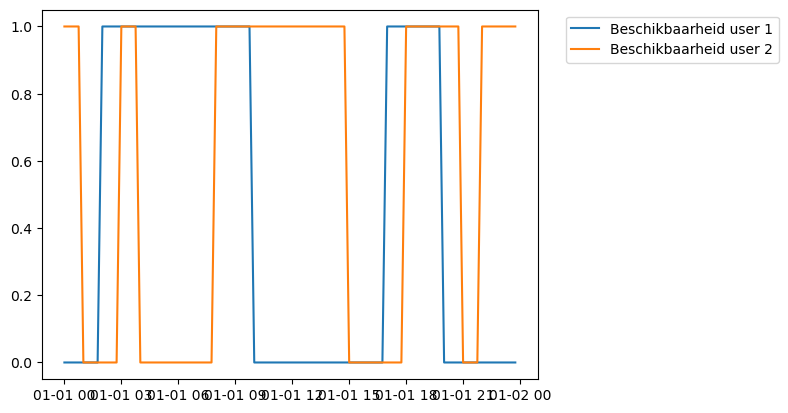

In [ ]:
plt.figure()
plt.plot(df.timestamp.iloc[:96], df.Beschikbaarheidsprofiel1.iloc[:96])
plt.plot(df.timestamp.iloc[:96], df.Beschikbaarheidsprofiel2.iloc[:96])
plt.legend(['Beschikbaarheid user 1','Beschikbaarheid user 2'], loc='upper right', bbox_to_anchor=(1.5, 1))


In [ ]:
# Dom laden: op elk tijdsstip t vraagt elke auto die wilt laden, max vermogen. Als boven cap: verschil met cap/#ladende auto's aftrekken van geladen vermogen.

In [ ]:
# Make Tz
status = 0
start = 0
stop = 0
Tz_user1 = []
for t in range(len(df.Beschikbaarheidsprofiel1.iloc[0:96])):
    if df.Beschikbaarheidsprofiel1.iloc[t] == 1 and status==0:
        start = t
        status = 1
    elif df.Beschikbaarheidsprofiel1.iloc[t] == 0 and status==1: #in deze t laadt hij niet meer, maar in de vorige wel nog -> stop = t
        stop = t
        status = 0
        Tz_user1.append((start,stop))

status = 0
start = 0
stop = 0
Tz_user2 = []
for t in range(len(df.Beschikbaarheidsprofiel2.iloc[0:96])):
    if df.Beschikbaarheidsprofiel2.iloc[t] == 1 and status==0:
        start = t
        status = 1
    elif df.Beschikbaarheidsprofiel2.iloc[t] == 0 and status==1: #in deze t laadt hij niet meer, maar in de vorige wel nog -> stop = t
        stop = t
        status = 0
        Tz_user2.append((start,stop))

Tz = [Tz_user1, Tz_user2]
print(Tz)

[[(8, 40), (68, 80)], [(0, 4), (12, 16), (32, 60), (72, 84)]]


In [ ]:
max_charge_rates = [users[0].get('user')[0], users[1].get('user')[0]]

In [ ]:
print(users[1].get('demandprof'))
print(users[0].get('user'))

[(0.5, 1), (0.1, 0.9), (0.6, 1), (0.4, 1), (0.5, 1)]
[5, 50]


In [ ]:
demand = [[0,0], [0,0,0,0,0]]
for i in range(2):
    for y in range(len(demand[i])):
        demand[i][y] = (users[i].get('demandprof')[y][1]-users[i].get('demandprof')[y][0])*users[i].get('user')[1]*1000*4

print(demand)

[[120000.0, 60000.00000000001], [140000.0, 224000.0, 112000.0, 168000.0, 140000.0]]


In [ ]:
model = LpProblem(name='laadpaalstudie', sense=LpMinimize)
Z = [2,3] #number of times the car is at the chargingstation within simulation period (T), Z = len(Tz)
T = 24*4 #timesteps in hour resolution
cap = 20000
C = 2 #number of charging stations
# Tz = [[(1*4,6*4),(18*4,22*4)], [(3*4,4*4),(10*4,15*4),(19*4,22*4)]]
# demand = [[3000*4,5000*4],[1000*4,2000*4,6000*4]] #in Watt-kwartier
priority = [1,1] #According to users: least priority gets 1, next 2, next 3,... len(priority) = C


zcharge = LpVariable.dicts('zcharge', [(c,z) for c in range(C) for z in range(Z[c])], lowBound=0, upBound= max_charge_rate)#[max_charge_rates[c] for c in range(C)])
tcharge = LpVariable.dicts('tcharge', [(c,t) for c in range(C) for t in range(T)], lowBound=0, upBound=max_charge_rate)#[max_charge_rates[c] for c in range(C)])

obj = lpSum([(demand[c][z] - zcharge[(c,z)])*priority[c] for c in range(C) for z in range(Z[c])])
model += obj


for t in range(T):
    model += (lpSum(tcharge[(c,t)] for c in range(C)) + np.array(df['Gemeenschappelijk verbruik in kW'].iloc[t])*1000 - np.array(df['Productie in kW'].iloc[t])*1000 <= cap)
    
for c in range(C):
    for z in range(Z[c]):
        model += (zcharge[(c,z)] == lpSum([tcharge[(c,t)] for t in range(Tz[c][z][0],Tz[c][z][1])]))

        model += (zcharge[(c,z)] <= demand[c][z])



# Solve the problem
status = model.solve(use_mps=False)

print(f"status: {model.status}, {LpStatus[model.status]}")


print(f"objective: {model.objective.value()}")


for var in model.variables():
    print(f"{var.name}: {var.value()}")



status: 1, Optimal
objective: 628500.0
tcharge_(0,_0): 0.0
tcharge_(0,_1): 0.0
tcharge_(0,_10): 0.0
tcharge_(0,_11): 0.0
tcharge_(0,_12): 0.0
tcharge_(0,_13): 0.0
tcharge_(0,_14): 0.0
tcharge_(0,_15): 0.0
tcharge_(0,_16): 0.0
tcharge_(0,_17): 5500.0
tcharge_(0,_18): 0.0
tcharge_(0,_19): 0.0
tcharge_(0,_2): 0.0
tcharge_(0,_20): 0.0
tcharge_(0,_21): 0.0
tcharge_(0,_22): 0.0
tcharge_(0,_23): 0.0
tcharge_(0,_24): 0.0
tcharge_(0,_25): 0.0
tcharge_(0,_26): 0.0
tcharge_(0,_27): 0.0
tcharge_(0,_28): 0.0
tcharge_(0,_29): 0.0
tcharge_(0,_3): 0.0
tcharge_(0,_30): 0.0
tcharge_(0,_31): 0.0
tcharge_(0,_32): 0.0
tcharge_(0,_33): 0.0
tcharge_(0,_34): 0.0
tcharge_(0,_35): 0.0
tcharge_(0,_36): 0.0
tcharge_(0,_37): 0.0
tcharge_(0,_38): 0.0
tcharge_(0,_39): 0.0
tcharge_(0,_4): 0.0
tcharge_(0,_40): 0.0
tcharge_(0,_41): 0.0
tcharge_(0,_42): 0.0
tcharge_(0,_43): 0.0
tcharge_(0,_44): 0.0
tcharge_(0,_45): 0.0
tcharge_(0,_46): 0.0
tcharge_(0,_47): 0.0
tcharge_(0,_48): 0.0
tcharge_(0,_49): 0.0
tcharge_(0,_5): 0.

In [ ]:
# zcharge_arr = np.zeros([(c,z) for c in range(C) for z in range(Z[c])])
tcharge_arr = np.zeros((C,T))
for c in range(C):
    for t in range(T):
        tcharge_arr[(c,t)] = tcharge[(c,t)].value()
    # for z in range(Z[c]):
    #     zcharge_arr[(c,z)] = zcharge[(c,z)].value()

In [ ]:
print(T)

96


In [ ]:
print(np.array(df.Beschikbaarheidsprofiel1.iloc[:96]))

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


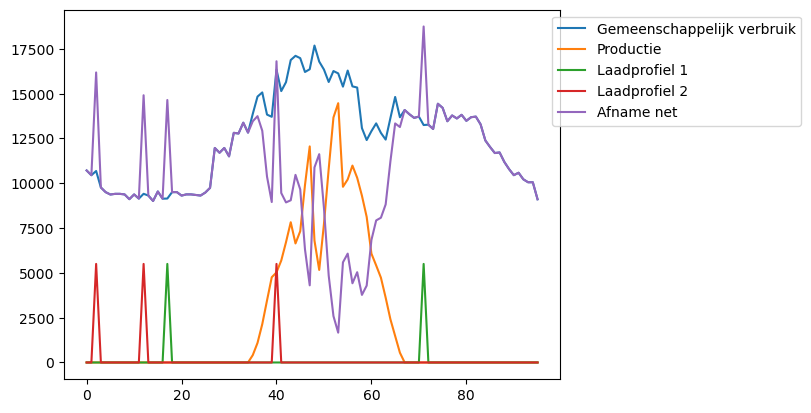

In [ ]:
plt.figure()
plt.plot(np.array(df['Gemeenschappelijk verbruik in kW'].iloc[0:T])*1000)
plt.plot(np.array(df['Productie in kW'].iloc[0:T])*1000)
plt.plot(tcharge_arr[0])
# plt.plot(np.array(df.Beschikbaarheidsprofiel1.iloc[:96])*cap)
plt.plot(tcharge_arr[1])
# plt.plot(np.array(df.Beschikbaarheidsprofiel2.iloc[:96])*cap)
plt.plot(tcharge_arr[0] + tcharge_arr[1] + np.array(df['Gemeenschappelijk verbruik in kW'].iloc[0:T])*1000 - np.array(df['Productie in kW'].iloc[0:T])*1000)
plt.legend(['Gemeenschappelijk verbruik', 'Productie', 'Laadprofiel 1', 'Laadprofiel 2', 'Afname net'], loc='upper right', bbox_to_anchor=(1.5, 1))
#, 'Beschikbaarheid 1','Beschikbaarheid 2'


# for c in range(C):
#     plt.plot(tcharge_arr[c])
#     # plt.plot(zcharge_arr[c])
# print(tcharge_arr[0], tcharge_arr[1])
# # print(zcharge_arr[1])